In [1]:
import os
import sys

cwd = os.getcwd()
sys.path.insert(0, cwd + "/src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from dendrotweaks.morphology.io.factory import TreeFactory, SWCReader

In [4]:
file_name = 'Park_2019.swc'
# file_name = 'Smith_2013_cat.swc'
# file_name ='final_figure_extra-000.swc'
file_name = 'ball-and-stick.swc'

path_to_swc = os.path.join(cwd, "data", file_name.replace('.swc', ''), "swc")
path_to_file = os.path.join(path_to_swc,file_name)

In [5]:
factory = TreeFactory()
reader = SWCReader()

In [6]:
df = reader.read_file(path_to_file)

In [7]:
df.head()

,Index,Type,X,Y,Z,R,Parent
0,1,1,0,0,0,10.0,-1
1,2,1,-10,0,0,10.0,1
2,3,1,10,0,0,10.0,1
3,4,3,-10,-10,0,2.0,1
4,5,3,-100,-100,0,2.0,4


In [8]:
# Count the number of each type of node
df.Type.value_counts()

4    10
3     4
1     3
Name: Type, dtype: int64

In [9]:
df['R'].unique()

array([10.  ,  2.  ,  1.  ,  0.5 ,  0.25])

In [10]:
# Show the summary statistics of the coordinates
df[['X', 'Y', 'Z']].describe()

,X,Y,Z
count,17.00000,17.000000,17.0
mean,0.00000,175.882353,0.0
std,93.67497,220.001671,0.0
min,-200.00000,-100.000000,0.0
25%,-10.00000,0.000000,0.0
50%,0.00000,100.000000,0.0
75%,10.00000,400.000000,0.0
max,200.00000,500.000000,0.0


In [11]:
# switch y and z columns
if file_name == 'final_figure_extra-000.swc':
    # swcm.df[['y', 'z']] = swcm.df[['z', 'y']]
    df.loc[df.Type == 2, 'Type'] = 4
    df.sort_values('Type', inplace=True)

In [12]:
# Show min and max idx for each node type
df.groupby('Type').agg({'Index': ['min', 'max']})

Index    
       min max
Type          
1        1   3
3        4   7
4        8  17

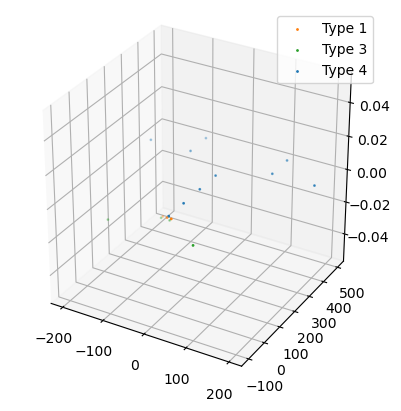

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect='equal')

reader.plot_raw_data(df, ax)

# SWC Tree

## Connect

We will now use the dataframe to create the tree representation of the cell.

In [14]:
swc_tree = factory.create_swc_tree(df)

Connecting tree.


In [15]:
swc_tree.root.subtree == swc_tree._nodes

True

In [16]:
swc_tree

Tree [•1, •2, •3, •4, •5, •6, •7, •8, •9, •10, •11, •12, •13, •14, •15, •16, •17]

In [17]:
swc_tree.is_connected

True

## Sort

We now want to make sure that the nodes are properly sorted. For this we will perform depth-first traversal of the tree and update a node's index as we visit the node.

In [18]:
swc_tree.sort()

  Elapsed time: 0.0 seconds


In [19]:
swc_tree.is_sorted

True

In [20]:
swc_tree

Tree [•0, •1, •2, •3, •4, •5, •6, •7, •8, •9, •10, •11, •12, •13, •14, •15, •16]

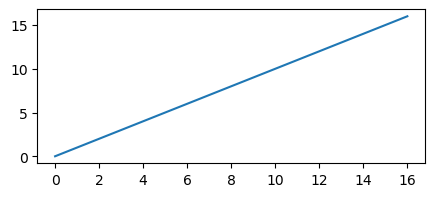

In [21]:
plt.figure(figsize=(5, 2))
plt.plot([node.idx for node in swc_tree._nodes])

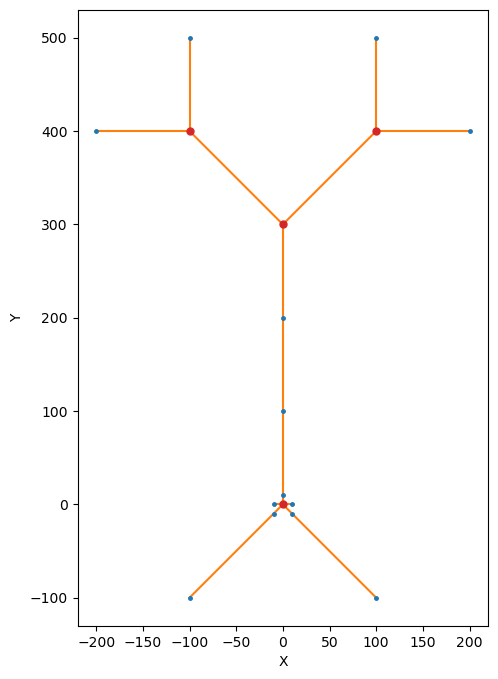

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
swc_tree.plot(ax, edges=True, projection='XY', 
              annotate=False, hightlight=swc_tree.bifurcations)

In [23]:
# swcm.swc_tree.topology()

## Shift and rotate

In [24]:
swc_tree.soma_center

array([0., 0., 0.])

In [25]:
swc_tree.apical_center

array([  0., 321.,   0.])

In [26]:
swc_tree.df

,idx,type_idx,x,y,z,r,parent_idx
0,0,1.0,0.0,0.0,0.0,10.00,-1
1,1,1.0,-10.0,0.0,0.0,10.00,0
2,2,1.0,10.0,0.0,0.0,10.00,0
3,3,3.0,-10.0,-10.0,0.0,2.00,0
4,4,3.0,-100.0,-100.0,0.0,2.00,3
5,5,3.0,10.0,-10.0,0.0,2.00,0
6,6,3.0,100.0,-100.0,0.0,2.00,5
7,7,4.0,0.0,10.0,0.0,2.00,0
8,8,4.0,0.0,100.0,0.0,2.00,7
9,9,4.0,0.0,200.0,0.0,1.00,8


In [27]:
swc_tree.shift_coordinates_to_soma_center()

In [28]:
swc_tree.align_apical_dendrite(axis='Y', facing='up')

Apical dendrite is already aligned.


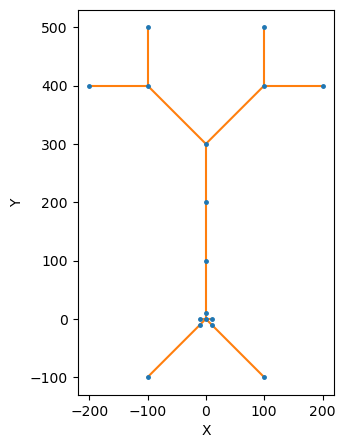

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))
swc_tree.plot(ax, edges=True, annotate=False, projection='XY')
# swcm.swc_tree.rotate(45, axis='Y')


In [30]:
swc_tree.soma_notation

'3PS'

# Section tree

In [31]:
sec_tree = factory.create_sec_tree(swc_tree, extend=True)

Extended 6 nodes.
Connecting tree.


In [32]:
sec_tree.soma.pts3d

[•1, •0, •2]

Not that we have set the `extend` flag to False and we will do extension manually for the purpose of this tutorial.

## Extending sections (manually)

Let's now visualize an arbitrary section (blue) and its parent section (orange). As you might notice the section appears detached from its parent. This is typical for SWC files, however, for our model we will need to recover this missing point. We can do it with extend section method.

WARNING: Note that we are using the hidden `swc_tree._sections` attribute only to explain the underlying algorithm. You shouln't use it at this stage because the sections have not been assigned `children` attribute. To work with sections we will further build a properly connected `SectionTree` instance.

In [33]:
selected_section = sec_tree.sections[1] #17

In [34]:
selected_section.pts3d[0].df

,idx,type_idx,x,y,z,r,parent_idx
0,3,3.0,-10.0,-10.0,0.0,2.0,0


In [35]:
selected_section.parent.pts3d[-1].df

,idx,type_idx,x,y,z,r,parent_idx
0,2,1.0,10.0,0.0,0.0,10.0,0


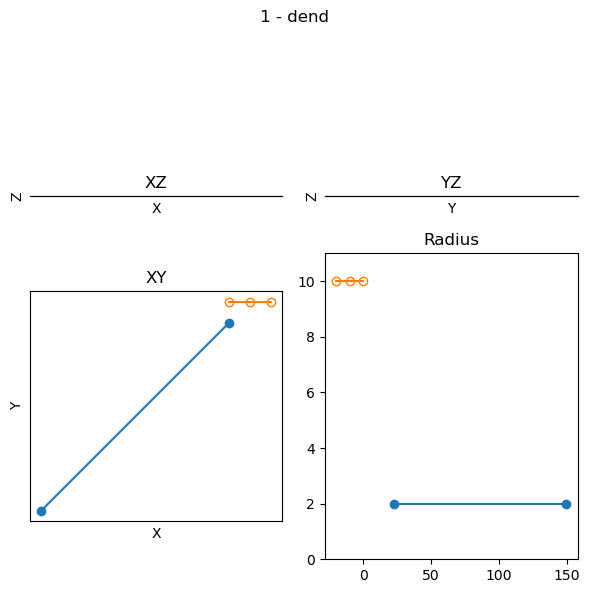

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
selected_section.plot(ax=ax, plot_parent=True, remove_ticks=True);
plt.tight_layout()

As you can see now, we have added a point in the beginning of our section that has the same coordinates as the point from the end of its parent section. And we did this for all points besides the soma children as we assume the soma has some spherical shape and the soma children do not start immediately from the soma center.

In [37]:
sec_tree.topology()

parent |   idx
---------------
    -1 |   •0
     0 |   ├─•1
     0 |   ├─•2
     0 |   └─•3
     3 |     ├─•4
     4 |     │ ├─•5
     4 |     │ └─•6
     3 |     └─•7
     7 |       ├─•8
     7 |       └─•9


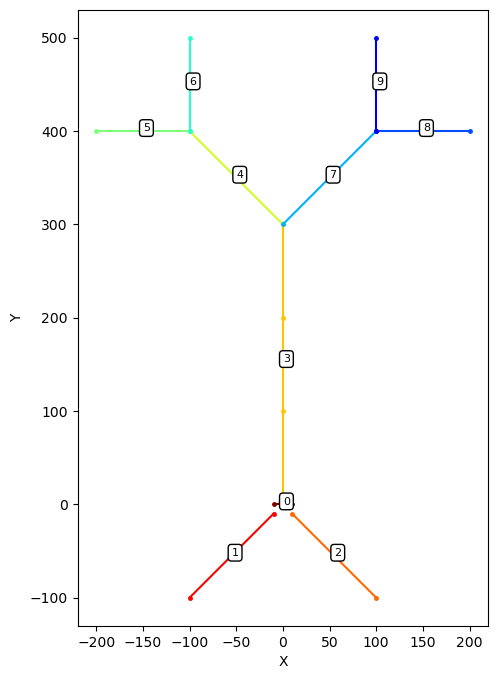

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
sec_tree.plot(ax=ax, show_points=True, show_lines=True, annotate=True, projection='XY')

In [42]:
for sec in sec_tree.sections:
    print(sec.idx, sec.distance_to_root(0))

0 0
1 14.142135623730951
2 14.142135623730951
3 10.0
4 300.0
5 441.4213562373095
6 441.4213562373095
7 300.0
8 441.4213562373095
9 441.4213562373095
